<a href="https://colab.research.google.com/github/MUMADE-TADM/s1_python-MariaMartin42/blob/main/TADM2022_Razonamiento_Aproximado_Naive_Bayes_Mar%C3%ADa_Mart%C3%ADn_Moreno_Alises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos a operar de diferentes maneras con los préstamos de nuestro banco, en concreto vamos a intentar crear clasificadores para que dadas unas variables nos den la probabilidad o el rating de darle un préstamo a un cliente

## Carga de Datos

In [1]:
!gdown --id 1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU
To: /content/data_berka.db
100% 70.2M/70.2M [00:00<00:00, 247MB/s]


1. Cargamos la extensión sql

In [2]:
%load_ext sql

2. Nos conectamos con la base de datos

In [3]:
%sql sqlite:///data_berka.db

'Connected: @data_berka.db'

> Datos de préstamos ya finalizados con su estado final, incluyendo datos del distrito, etc.

¿Cuántos préstamos hay por cada estado?

In [4]:
%%sql 
SELECT status, count(*) as total
FROM LOAN
GROUP BY status
ORDER BY total DESC

 * sqlite:///data_berka.db
Done.


status,total
C,403
A,203
D,45
B,31


Vamos a empezar obteniendo los datos de los préstamos ya finalizados. Van a ser nuestros datos de entrenamiento. Por lo que seleccionaremos únicamente aquellos préstamos en status 'A' o 'B'. 

Con una sentencia CASE vamos a poner los prestamos finalizados bien a 1 y los que no finalizaron bien a 0. 

Sintaxis de uso de [INNER JOIN](https://www.sqlitetutorial.net/sqlite-inner-join/) para establecer joins entre tablas

In [5]:
%%sql loans_train << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0

  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("A", "B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train


3. Obtenemos el DataFrame

In [6]:
df_train = loans_train.DataFrame()
df_train.head()

,year,amount,duration,payments,A11,A13,label
0,93,96396,12,8033,9650,3.67,0
1,93,165960,36,4610,8369,2.31,1
2,93,127080,60,2118,8390,2.89,1
3,93,105804,36,2939,8754,4.31,1
4,93,274740,60,4579,12541,0.43,1


In [7]:
df_train.shape

(234, 7)

In [8]:
%%sql loans_test << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13, 
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test


Ejercicio: Añadir la edad del cliente propietario de la cuenta del prestamo.


In [9]:
%%sql
SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
CASE status WHEN 'A' THEN 1
            WHEN 'B' THEN 0
END label 
FROM LOAN l, ACCOUNT a, DISTRICT d, CLIENT c, DISPOSITION disp
WHERE c.district_id = d.A1
AND l.account_id = a.account_id 
AND a.account_id = disp.account_id
AND disp.client_id = c.client_id
AND l.status in ("A", "B")
LIMIT 20

 * sqlite:///data_berka.db
Done.


year,amount,duration,payments,A11,A13,label
94,80952,24,3373,12541,0.43,1
94,80952,24,3373,12541,0.43,1
96,30276,12,2523,9104,2.07,0
97,30276,12,2523,9893,4.72,1
96,165960,24,6915,8427,1.54,1
97,102876,12,8573,10673,5.44,1
97,102876,12,8573,10673,5.44,1
96,88440,12,7370,9317,7.07,1
96,88440,12,7370,9317,7.07,1
94,104808,12,8734,8512,4.12,1


In [10]:
df_test = loans_test.DataFrame()
df_test.head()

,year,amount,duration,payments,A11,A13,label
0,94,253200,60,4220,9893,4.72,1
1,94,300660,60,5011,9317,7.07,1
2,94,167100,60,2785,8544,1.86,1
3,94,149340,60,2489,8254,3.76,1
4,94,89040,60,1484,8909,5.56,1


4. División de los datos en entrenamiento y test

In [11]:
features = ["year", "amount", "duration", "payments","A11", "A13"]

In [12]:
X_train = df_train[features]
y_train = df_train["label"]

X_test = df_test[features]
y_test = df_test["label"]


5. Normalizarlos puede ser una buena medida para obtener mejores resultados.
Para ello vamos a utilizar el [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

El centrado y el escalado se realizan de forma independiente en cada característica, calculando las estadísticas pertinentes en las muestras del **conjunto de entrenamiento**. La media y la desviación estándar se almacenan para utilizarlas en datos posteriores mediante una **transformación**.

Mas información sobre normalización en el siguiente [enlace](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler)


In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train) 
# transformación
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Aplicamos un modelo [NaiveBayes](https://scikit-learn.org/stable/modules/naive_bayes.html?highlight=naive+bayes) para construir un clasificador de préstamos

In [14]:
from sklearn.naive_bayes import GaussianNB #, MultinomialNB, BernoulliNB, ComplementNB

gnb = GaussianNB()
clf = gnb.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test.shape[0], (y_test != y_pred).sum()))


Número de préstamos clasificados erroneamente 448 de un total de  123


Para ver que resultados tenemos sobre la colección de `test` utilizamos en primer lugar el informe de los resultados [`classification report`](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.20      0.60      0.31        45
           1       0.94      0.74      0.83       403

    accuracy                           0.73       448
   macro avg       0.57      0.67      0.57       448
weighted avg       0.87      0.73      0.78       448



Y la [matriz de confusión](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

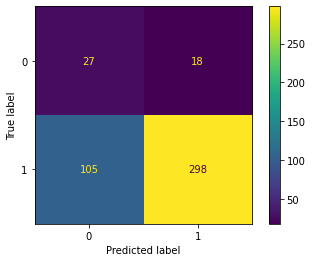

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

**Ejercicios**

Plantear el clasificador de préstamos añadiendo datos de otras tablas de la base de datos, u otros campos de las mismas tablas (edad del cliente, etc).

Otras transformaciones: [Discretización](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-discretization) y utilización de otros clasificadores NB

CARGA DE DATOS

In [1]:
!gdown --id 1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU
To: /content/data_berka.db
100% 70.2M/70.2M [00:01<00:00, 58.9MB/s]


1.Carga de la extensión sql

In [2]:
%load_ext sql

2. Conexión con la base de datos

In [3]:
%sql sqlite:///data_berka.db

'Connected: @data_berka.db'

Sintaxis de uso de INNER JOIN para establecer joins entre tablas

In [ ]:
%%sql loans_train2 << SELECT substr(l.date,0,3) year, l.amount, duration, payments, A10 as r_urban_inhabitants , po.amount, po.account_to as account_recipient,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0

  END label
  FROM LOAN l INNER JOIN DISTRICT d
              INNER JOIN PERMANENT_ORDER po
              INNER JOIN ACCOUNT a on l.account_id = a.account_id = po.account_id
             
  WHERE l.status in ("A", "B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train2


In [16]:
%%sql loans_train2 << SELECT substr(l.date,0,3) year, l.amount, 99-substr(c.birth_number,0,3)age, duration, payments, A10 as r_urban_inhabitants, A13 as unemployement_96, po.amount,
CASE status WHEN 'A' THEN 1
            WHEN 'B' THEN 0 
END label
FROM ACCOUNT a INNER JOIN LOAN l on a.account_id = l.account_id = po.account_id
               INNER JOIN DISTRICT d on a.district_id = d.A1 = c.district_id
               INNER JOIN PERMANENT_ORDER po
               INNER JOIN CLIENT c
WHERE l.status in ("A","B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train2


Obtención del DataFrame

In [17]:
df_train2 = loans_train2.DataFrame()
df_train2.head()

,year,amount,age,duration,payments,r_urban_inhabitants,unemployement_96,amount,label
0,93,96396,86,12,8033,81.8,3.67,2452,0
1,93,96396,84,12,8033,81.8,3.67,2452,0
2,93,96396,82,12,8033,81.8,3.67,2452,0
3,93,96396,82,12,8033,81.8,3.67,2452,0
4,93,96396,81,12,8033,81.8,3.67,2452,0


In [18]:
df_train2.shape

(155142, 9)

Datos test:

In [19]:
%%sql loans_test2 << SELECT substr(l.date,0,3) year, l.amount, 99-substr(c.birth_number,0,3)age, duration, payments, A10 as r_urban_inhabitants, A13 as unemployement_96, po.amount,
CASE status WHEN 'C' THEN 1
            WHEN 'D' THEN 0 
END label
FROM ACCOUNT a INNER JOIN LOAN l on a.account_id = l.account_id = po.account_id
               INNER JOIN DISTRICT d on a.district_id = d.A1 = c.district_id
               INNER JOIN PERMANENT_ORDER po
               INNER JOIN CLIENT c
WHERE l.status in ("C","D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test2


In [20]:
df_test2 = loans_test2.DataFrame()
df_test2.head()

,year,amount,age,duration,payments,r_urban_inhabitants,unemployement_96,amount,label
0,94,253200,86,60,4220,57.2,4.72,2452,1
1,94,253200,84,60,4220,57.2,4.72,2452,1
2,94,253200,82,60,4220,57.2,4.72,2452,1
3,94,253200,82,60,4220,57.2,4.72,2452,1
4,94,253200,81,60,4220,57.2,4.72,2452,1


In [22]:
df_test2.shape

(297024, 9)

3. División de datos de entrenamiento y test

In [23]:
features = ["year", "amount", "age", "duration", "payments", "r_urban_inhabitants","unemployement_96", "amount","label"]

In [24]:
X_train2 = df_train2[features]
y_train2 = df_train2["label"]

X_test2 = df_test2[features]
y_test2 = df_test2["label"]


4. Normalizar los resultados.

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train2) 
# transformación
X_train = scaler.transform(X_train2)
X_test = scaler.transform(X_test2)

Aplicación de NaiveBayes

In [26]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
clf = gnb.fit(X_train2, y_train2)
y_pred2 = clf.predict(X_test2)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test2.shape[0], (y_test2 != y_pred2).sum()))

Número de préstamos clasificados erroneamente 297024 de un total de  106080


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test2, y_pred2, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.17      0.64      0.27     29835
           1       0.94      0.64      0.76    267189

    accuracy                           0.64    297024
   macro avg       0.55      0.64      0.52    297024
weighted avg       0.86      0.64      0.71    297024



Matriz de confusión:

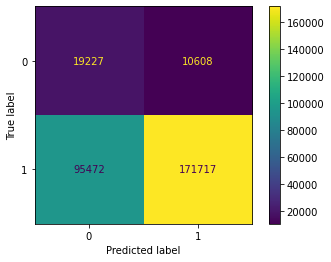

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test2, y_pred2, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

En este caso, para realizar la nueva matriz de confusión se han tenido nuevos datos en cuenta como: 
-Edad: ya que es una variable importante a la hora de la concesión de préstamos debido a su posible disponibilidad de tiempo para hacer frente a la deuda. 
-Ratio de desempleo: se ha considerado importante para saber si el cliente podrá hacer frente al préstamo. 
-Cantidad del préstado (cantidad endeudada): se ha considerado importante, ya que si la cantidad solicitada es mayor, su concesión será más difícil según las condiciones del cliente.